In [87]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

import random
from tqdm import tqdm
import time 

# Generator Function 

In [88]:
# Noise Range between -2 and 2 --> Return tensor with length seq_len
# Target if integral
def integration_task(seq_len, num_samples, r = 2):
    for i in range(num_samples):
        noise_sample = []
        for j in range(seq_len):
            noise_sample.append(random.uniform(-r, r))
        target = np.trapz(noise_sample)
        if target < 0: target = -1
        else: target = 1
        yield noise_sample, target



In [89]:
noise_gen = integration_task(seq_len = 10, num_samples = 3, r = 2)
noise_func1, noise_target1 = next(noise_gen)
noise_func2, noise_target2 = next(noise_gen)
noise_func3, noise_target3 = next(noise_gen)




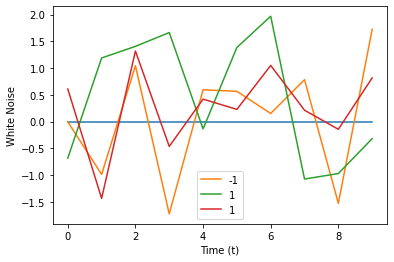

In [90]:
plt.figure()
line0, = plt.plot(np.zeros_like(noise_func1))
line1, = plt.plot(noise_func1)
line2, = plt.plot(noise_func2)
line3, = plt.plot(noise_func3)
plt.xlabel("Time (t)")
plt.ylabel("White Noise")
plt.legend((line1,line2,line3),(str(noise_target1), str(noise_target2), str(noise_target3)))
plt.show()

# Wrapper Function for integration task

In [98]:
def my_integration_task():
    SEQ_LENGTH = 10
    NUM_SAMPLES = 10

    for i in len(list(integration_task(SEQ_LENGTH, NUM_SAMPLES)))
        yield next(integration_task(SEQ_LENGTH, NUM_SAMPLES))

In [99]:
integration = my_integration_task()
while next(integration):
    print(next(integration))

([1.9993876243753586, -0.014837757840991284, 1.172212645402968, 0.23143511392975302, -0.14588115165023563, -1.1986057934617542, 1.5559553012639067, 1.8580867451001324, 1.8229428324701407, -0.20538873670651414], 1)
([1.9901399259823531, -0.74559376751772, 0.5549148407620268, -1.4743421735431177, 0.5232801981154913, 0.3330306027729595, 1.765071032906639, -0.05216132320409983, 1.8502944541058488, -1.5035119418848533], 1)
([1.6076299801307417, -0.2932120204901705, 0.04587525135669379, -1.5292096829360733, 1.0386313368878, -0.9628890621569726, -0.4169975681145264, 0.8045751214972081, 1.8616800851364284, 1.665861107415851], 1)
([1.4204112792458492, 1.4266885009167982, 1.5389868046475672, 1.3321892310430576, 0.6520405407182395, -1.526083672898455, 0.319320930690814, -1.7892975773750859, -0.16413604461877984, -0.9156603011506914], 1)
([1.8113969326438695, 0.1469385055838397, 0.6099158117620944, 1.0612827770935316, -0.545719588569952, -1.143163172259161, 0.7482082993177546, -1.1292630384133182,

StopIteration: 